In [234]:
from astropy.io import fits
import numpy as np
import glob
import matplotlib.pyplot as plt
import ccdproc
from astropy import units as u
import re
from astropy.stats import sigma_clip
from scipy.ndimage import shift, center_of_mass
from photutils.centroids import centroid_com
import os
import astroscrappy
from scipy.stats import linregress
import pandas as pd
from scipy.optimize import curve_fit
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from astropy.nddata import Cutout2D

my_path = "/Users/yzb4en/Downloads/TOI-2046b"

## Reduce the Data

In [192]:
bias_files = sorted(glob.glob(f"{my_path}/Bias_BIN2_20251031_*.fits"))

bias_stack = []
for f in bias_files:
    with fits.open(f) as hdul:
        bias_stack.append(hdul[0].data.astype(float))

master_bias = np.median(np.stack(bias_stack, axis=0), axis=0)
fits.writeto(f"{my_path}/master_bias.fits", master_bias, overwrite=True)

In [193]:
dark_files = sorted(glob.glob(f"{my_path}/Dark_BIN2_20251031_*.fits"))

dark_corr = []
for f in dark_files:
    with fits.open(f) as hdul:
        dark_corr.append(hdul[0].data.astype(float) - master_bias)

master_dark = np.median(np.stack(dark_corr, axis=0), axis=0)
fits.writeto(f"{my_path}/master_dark.fits", master_dark, overwrite=True)

In [194]:
flat_files = sorted(glob.glob(f"{my_path}/domeflat_g_*-2.fits"))

flat_corr = []
for f in flat_files:
    with fits.open(f) as hdul:
        img = hdul[0].data.astype(float)
        img = img - master_bias - master_dark
        flat_corr.append(img)

master_flat = np.median(np.stack(flat_corr, axis=0), axis=0)
fits.writeto(f"{my_path}/master_flat.fits", master_flat, overwrite=True)

In [195]:
sci_files = sci_files = sorted(f for f in glob.glob(f"{my_path}/TOI-2046b_g_20251031_*.fits") if not f.endswith("_reduced.fits"))

master_bias = fits.getdata(f"{my_path}/master_bias.fits").astype(float)
master_dark = fits.getdata(f"{my_path}/master_dark.fits").astype(float)
master_flat = fits.getdata(f"{my_path}/master_flat.fits").astype(float)

# Build 1D flat response
flat_response = np.median(master_flat, axis=0)
flat_response /= np.median(flat_response)
flat_response[flat_response == 0] = 1.0

for sci_file in sci_files:
    with fits.open(sci_file) as hdul:
        sci = hdul[0].data.astype(float)
        hdr = hdul[0].header

    # Exposure time
    exptime = float(hdr['EXPTIME'])  # seconds

    # Scale dark to science exposure time
    dark_scaled = master_dark * (exptime / 300.0)

    # Subtract bias and dark
    sci_corr = sci - master_bias - dark_scaled

    # Divide by 1D flat response
    sci_corr /= flat_response[np.newaxis, :]

    # Save reduced file
    outname = sci_file.replace(".fits", "_reduced.fits")
    fits.writeto(outname, sci_corr, hdr, overwrite=True)

In [196]:
# check if we need overscan subtraction (this shows we don't)

def check_overscan(fpath):
    """
    Inspect FITS header and data for overscan regions.
    Returns a dict with header info and simple statistics.
    """
    with fits.open(fpath) as hdul:
        hdr = hdul[0].header
        data = hdul[0].data.astype(float)

    info = {"file": fpath}

    # Look for standard overscan keywords
    info["BIASSEC"] = hdr.get("BIASSEC", None)
    info["TRIMSEC"] = hdr.get("TRIMSEC", None)

    # If overscan keywords exist, parse them
    if info["BIASSEC"]:
        # Example: '[2050:2100,1:2048]'
        sec = info["BIASSEC"].strip("[]").split(",")
        x1, x2 = map(int, sec[0].split(":"))
        y1, y2 = map(int, sec[1].split(":"))
        overscan_region = data[y1-1:y2, x1-1:x2]
        info["overscan_mean"] = np.mean(overscan_region)
        info["overscan_std"] = np.std(overscan_region)
    else:
        info["overscan_mean"] = None
        info["overscan_std"] = None

    # Compare median of science region vs overscan (if available)
    if info["overscan_mean"] is not None:
        trimmed_region = None
        if info["TRIMSEC"]:
            sec = info["TRIMSEC"].strip("[]").split(",")
            x1, x2 = map(int, sec[0].split(":"))
            y1, y2 = map(int, sec[1].split(":"))
            trimmed_region = data[y1-1:y2, x1-1:x2]
        else:
            trimmed_region = data

        info["science_median"] = np.median(trimmed_region)
    else:
        info["science_median"] = np.median(data)

    return info

# Run checks on all science frames
for sci_file in sci_files:
    info = check_overscan(sci_file)
    print(f"\nFile: {info['file']}")
    print(f"  BIASSEC: {info['BIASSEC']}")
    print(f"  TRIMSEC: {info['TRIMSEC']}")
    print(f"  Overscan mean: {info['overscan_mean']}")
    print(f"  Overscan std: {info['overscan_std']}")
    print(f"  Science median: {info['science_median']}")


File: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040701.fits
  BIASSEC: None
  TRIMSEC: None
  Overscan mean: None
  Overscan std: None
  Science median: 1303.0

File: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040804.fits
  BIASSEC: None
  TRIMSEC: None
  Overscan mean: None
  Overscan std: None
  Science median: 1304.0

File: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040905.fits
  BIASSEC: None
  TRIMSEC: None
  Overscan mean: None
  Overscan std: None
  Science median: 1304.0

File: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041006.fits
  BIASSEC: None
  TRIMSEC: None
  Overscan mean: None
  Overscan std: None
  Science median: 1304.0

File: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041107.fits
  BIASSEC: None
  TRIMSEC: None
  Overscan mean: None
  Overscan std: None
  Science median: 1304.0

File: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041207.fits
  BIASSEC: None
  TRIMSEC: None
  Overscan mean: None
  

## Align Images and Sigma Clipping

In [197]:
def estimate_gain(bias_frames, sigma=3):
    """
    Estimate CCD gain and read noise from bias frames using the variance method.
    
    Parameters
    ----------
    bias_frames : list of str
        List of file paths to bias frames.
    sigma : float, optional
        Sigma threshold for sigma clipping (default=3).
    
    Returns
    -------
    gain : float
        Estimated gain in e-/ADU.
    """
    # Load all bias frames into a 3D array
    bias_data = np.array([fits.getdata(f).astype(float) for f in bias_frames])
    
    # Mean and variance per pixel across frames
    mean_image = np.mean(bias_data, axis=0)
    var_image = np.var(bias_data, axis=0, ddof=1)
    
    # Flatten and sigma-clip to remove outliers
    mean_flat = mean_image.flatten()
    var_flat = var_image.flatten()
    mean_clipped = sigma_clip(mean_flat, sigma=sigma)
    var_clipped = sigma_clip(var_flat, sigma=sigma)
    
    valid_mask = ~mean_clipped.mask & ~var_clipped.mask
    mean_valid = mean_flat[valid_mask]
    var_valid = var_flat[valid_mask]
    
    # Linear regression: variance = (mean - offset)/gain
    slope, intercept, _, _, _ = linregress(mean_valid, var_valid)
    print(f"Slope: {slope:.6e}, Intercept: {intercept:.6e}")
    
    # Gain
    gain = 1.0 / slope if slope > 0 else np.nan
    
    print(f"Estimated gain: {gain:.3f} e-/ADU")
    
    return gain

if len(bias_files) >= 5:
    gain = estimate_gain(bias_files[:10], sigma=3)
else:
    print("Warning: Not enough bias frames for gain/read noise estimation")
    gain = np.nan

Slope: 7.939528e-01, Intercept: -6.367305e+02
Estimated gain: 1.260 e-/ADU


In [198]:
def calculate_photon_noise(science_files, master_bias, master_dark, gain):
    """
    Calculate mean photon noise from science frames using master bias/dark and known gain.

    Parameters
    ----------
    science_files : list of str
        List of FITS science frame file paths.
    master_bias : 2D array
        Master bias frame in ADU.
    master_dark : 2D array
        Master dark frame in ADU (scaled to exposure time).
    gain : float
        CCD gain in e-/ADU.

    Returns
    -------
    mean_photon_noise : float
        Mean photon noise across all frames (in electrons).
    std_photon_noise : float
        Standard deviation of per-frame mean photon noise (in electrons).
    """
    per_file_means = []

    for f in science_files:
        with fits.open(f) as hdul:
            image_adu = hdul[0].data.astype(float)

        # Calibrate: subtract bias and dark
        calibrated_adu = image_adu - master_bias - master_dark

        # Convert to electrons
        N_e = gain * np.clip(calibrated_adu, a_min=0, a_max=None)

        # Photon noise per pixel
        photon_noise_e = np.sqrt(N_e)

        # Mean photon noise for this frame
        per_file_means.append(np.mean(photon_noise_e))

    per_file_means = np.array(per_file_means)

    # Mean and standard deviation across frames
    mean_photon_noise = float(np.mean(per_file_means))
    std_photon_noise = float(np.std(per_file_means, ddof=1))

    print(f"Mean photon noise: {mean_photon_noise:.3f} e-")
    print(f"Std dev of photon noise across frames: {std_photon_noise:.3f} e-")

    return mean_photon_noise, std_photon_noise

gain = 1.260
mean_photon_noise, std_photon_noise = calculate_photon_noise(sci_files, master_bias, master_dark, gain)

Mean photon noise: 11.313 e-
Std dev of photon noise across frames: 3.319 e-


In [199]:
def calculate_read_noise(bias_files, gain):
    """
    Calculate read noise from bias frames and known gain.

    Parameters
    ----------
    bias_files : list of str
        List of FITS bias frame file paths.
    gain : float
        CCD gain in e-/ADU.

    Returns
    -------
    mean_read_noise : float
        Mean read noise across all pixels (in electrons).
    std_read_noise : float
        Standard deviation of read noise across pixels (in electrons).
    """
    # Load all bias frames
    bias_stack = []
    for f in bias_files:
        with fits.open(f) as hdul:
            bias_stack.append(hdul[0].data.astype(float))
    bias_stack = np.stack(bias_stack, axis=0)

    # Compute variance across frames (per pixel) in ADU^2
    var_image = np.var(bias_stack, axis=0, ddof=1)

    # Convert variance to electrons^2
    var_image_e2 = (gain**2) * var_image

    # Per-pixel read noise (RMS in electrons)
    read_noise_map = np.sqrt(var_image_e2)

    # Mean and standard deviation across pixels
    mean_read_noise = float(np.mean(read_noise_map))
    std_read_noise = float(np.std(read_noise_map, ddof=1))

    print(f"Mean read noise: {mean_read_noise:.3f} e-")
    print(f"Std dev of read noise across pixels: {std_read_noise:.3f} e-")

    return mean_read_noise, std_read_noise

gain = 1.260  # e-/ADU
if len(bias_files) >= 5:
    read_noise = calculate_read_noise(bias_files, gain)
else:
    print("Not enough bias frames for reliable read noise estimation")

Mean read noise: 19.544 e-
Std dev of read noise across pixels: 3.650 e-


In [201]:
sci_files_red = sorted(glob.glob(f"{my_path}/TOI-2046b_g_20251031_*_reduced.fits"))

# Reference centroid (first frame)
with fits.open(sci_files_red[0]) as hdul:
    ref_img = hdul[0].data.astype(float)
ref_cy, ref_cx = centroid_com(ref_img)

# Instrument parameters
gain = 1.260      # e-/ADU
readnoise = 19.544  # e- (RMS)
satlevel = 60000  # set to your saturation ADU (e.g., 50000) if known

# L.A.Cosmic parameters (conservative defaults)
# - sigclip: detection threshold (increase to be more conservative)
# - sigfrac: fractional threshold for neighbors
# - objlim: star/CR discrimination; higher reduces false flags on stars
lac_kwargs = dict(
    sigclip=7.0,      # start at >7sig; increase if stars get hit
    sigfrac=0.3,      # neighbor fraction
    objlim=10.0,       # try 5–10; higher = safer for stellar cores
    gain=gain,
    readnoise=readnoise,
    satlevel=satlevel,
    niter=3,          # iterations; reduce if too aggressive
    sepmed=True,      # robust background estimation
    cleantype='medmask'  # median replacement within mask
)

for f in sci_files_red:
    with fits.open(f) as hdul:
        img = hdul[0].data.astype(float)
        hdr = hdul[0].header

    # align to reference by centroid
    cy, cx = centroid_com(img)
    dy, dx = (ref_cy - cy, ref_cx - cx)
    aligned = shift(img, shift=(dy, dx), mode="nearest")

    # run L.A.Cosmic
    crmask, cleaned = astroscrappy.detect_cosmics(aligned, **lac_kwargs)

    # save cleaned output (per file)
    outname = f.replace("_reduced.fits", "_rc.fits")
    fits.writeto(outname, cleaned, hdr, overwrite=True)

    # report outlier stats
    n_cr = int(np.sum(crmask))
    frac = n_cr / crmask.size
    print(f"{f}: cosmic rays flagged={n_cr} ({frac:.6f}) → {outname}")

/Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040701_reduced.fits: cosmic rays flagged=2337 (0.001001) → /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040701_rc.fits
/Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040804_reduced.fits: cosmic rays flagged=4242 (0.001817) → /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040804_rc.fits
/Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040905_reduced.fits: cosmic rays flagged=4277 (0.001832) → /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040905_rc.fits
/Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041006_reduced.fits: cosmic rays flagged=4386 (0.001879) → /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041006_rc.fits
/Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041107_reduced.fits: cosmic rays flagged=4206 (0.001801) → /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041107_rc.fits
/Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041207_reduced.fits: cosm

## Image Profiles

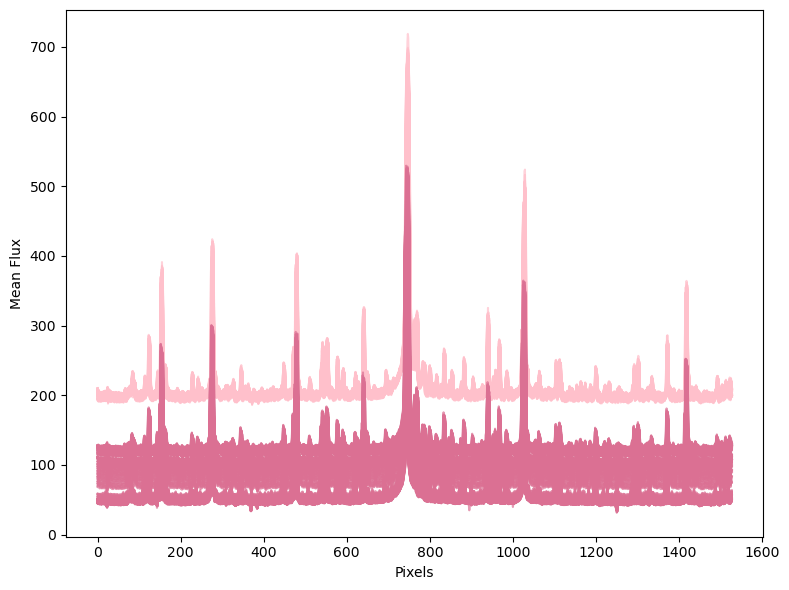

In [202]:
sci_files_rc = sorted(glob.glob(f"{my_path}/TOI-2046b_g_20251031_*_rc.fits"))

plt.figure(figsize=(8,6))

for fname in sci_files_rc:
    with fits.open(fname) as hdul:
        data = hdul[0].data.astype(float)
        hdr = hdul[0].header
        exptime = hdr.get("EXPTIME", None)  # exposure time keyword

        # Collapse along y-axis to get 1D profile
        profile = np.mean(data, axis=0)

        # Choose color based on exposure time
        if exptime == 45:
            color = "pink"
            label = "45s"
        elif exptime == 30:
            color = "palevioletred"
            label = "30s"
        else:
            color = "gray"

        plt.plot(profile, color=color, alpha=0.7)

plt.xlabel("Pixels")
plt.ylabel("Mean Flux")
plt.tight_layout()
plt.show()

=== Stability Analysis ===
Number of frames: 277
Mean PSF sigma: 3.266563515748143
Stddev PSF sigma: 0.36829259191216285
Centroid drift (x): 1.6126682439668147
Centroid drift (y): 1.106610806894732
Flux stability (mean/std): 118.57403762326285 31.05426175245947


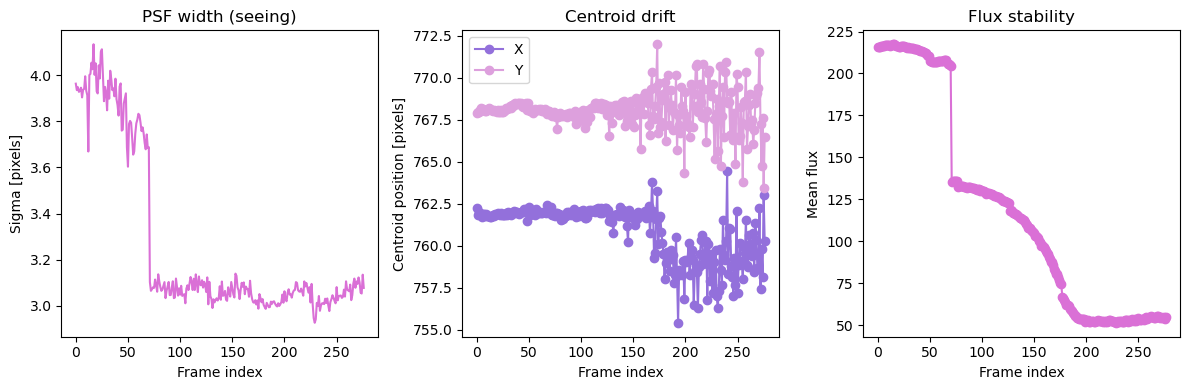

In [203]:
# --- Gaussian model for PSF fitting ---
def gaussian(x, amp, mu, sigma, offset):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2)) + offset

results = []

for fname in sci_files_rc:
    with fits.open(fname) as hdul:
        data = hdul[0].data.astype(float)
        hdr = hdul[0].header
        exptime = hdr.get("EXPTIME", None)

        # Collapse along y-axis to get 1D profile
        profile = np.mean(data, axis=0)
        x = np.arange(len(profile))

        # Fit Gaussian to profile
        try:
            p0 = [np.max(profile), np.argmax(profile), 5.0, np.min(profile)]
            popt, _ = curve_fit(gaussian, x, profile, p0=p0)
            amp, mu, sigma, offset = popt
        except RuntimeError:
            sigma = np.nan
            mu = np.nan

        # Centroid from center of mass
        cy, cx = center_of_mass(data)

        results.append({
            "file": fname,
            "exptime": exptime,
            "centroid_x": cx,
            "centroid_y": cy,
            "psf_sigma": sigma,
            "flux_mean": np.mean(profile),
            "flux_std": np.std(profile)
        })

# --- Convert results to arrays ---
df = pd.DataFrame(results)

# --- Statistical summaries ---
print("=== Stability Analysis ===")
print("Number of frames:", len(df))
print("Mean PSF sigma:", df['psf_sigma'].mean())
print("Stddev PSF sigma:", df['psf_sigma'].std())
print("Centroid drift (x):", df['centroid_x'].std())
print("Centroid drift (y):", df['centroid_y'].std())
print("Flux stability (mean/std):", df['flux_mean'].mean(), df['flux_std'].mean())

# --- Plots ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(df['psf_sigma'], '-', c='orchid')
plt.title("PSF width (seeing)")
plt.xlabel("Frame index")
plt.ylabel("Sigma [pixels]")

plt.subplot(1,3,2)
plt.plot(df['centroid_x'], 'o-', label="X", c='mediumpurple')
plt.plot(df['centroid_y'], 'o-', label="Y", c='plum')
plt.title("Centroid drift")
plt.xlabel("Frame index")
plt.ylabel("Centroid position [pixels]")
plt.legend()

plt.subplot(1,3,3)
plt.plot(df['flux_mean'], 'o-', c='orchid') # flux in ADU (I think)
plt.title("Flux stability")
plt.xlabel("Frame index")
plt.ylabel("Mean flux")

plt.tight_layout()
plt.show()

## Reference Stars

In [226]:
def crop(hdu, wcs):
    # Define half-widths of the cutout
    half_width_x = (765 - 745) / 2   
    half_height_y = (765 - 745) / 2 

    # Center position (pixels)
    position = (755 + half_width_x, 755 + half_height_y)

    # Cutout size (ny, nx)
    size = (int(2*half_height_y), int(2*half_width_x))

    cutout = Cutout2D(hdu.data, position, size, wcs=wcs)
    return cutout.data

for fname in sci_files_rc:
    with fits.open(fname) as hdul:
        hdu = hdul[0]
        wcs = None
        try:
            wcs = WCS(hdu.header)
        except Exception:
            pass

        cropped_data = crop(hdu, wcs)

        # Create new HDU with cropped data
        hdu_cropped = fits.PrimaryHDU(cropped_data, header=hdu.header)

        # Build output filename
        outname = fname.replace("_rc.fits", "_toi.fits")

        # Write to disk
        hdu_cropped.writeto(outname, overwrite=True)
        print(f"Saved cropped file: {outname}")

Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040701_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040804_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040905_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041006_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041107_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041207_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041308_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041409_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041510_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041611_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041712_toi.fits

In [218]:
def crop(hdu, wcs):
    # Define half-widths of the cutout
    half_width_x = (775 - 755) / 2   
    half_height_y = (835 - 815) / 2 

    # Center position (pixels)
    position = (765 + half_width_x, 825 + half_height_y)

    # Cutout size (ny, nx)
    size = (int(2*half_height_y), int(2*half_width_x))

    cutout = Cutout2D(hdu.data, position, size, wcs=wcs)
    return cutout.data

for fname in sci_files_rc:
    with fits.open(fname) as hdul:
        hdu = hdul[0]
        wcs = None
        try:
            wcs = WCS(hdu.header)
        except Exception:
            pass

        cropped_data = crop(hdu, wcs)

        # Create new HDU with cropped data
        hdu_cropped = fits.PrimaryHDU(cropped_data, header=hdu.header)

        # Build output filename
        outname = fname.replace("_rc.fits", "_ref1.fits")

        # Write to disk
        hdu_cropped.writeto(outname, overwrite=True)
        print(f"Saved cropped file: {outname}")

Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040701_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040804_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040905_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041006_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041107_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041207_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041308_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041409_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041510_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041611_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_04171

In [222]:
def crop(hdu, wcs):
    # Define half-widths of the cutout
    half_width_x = (1375 - 1355) / 2   
    half_height_y = (1000 - 980) / 2 

    # Center position (pixels)
    position = (1365 + half_width_x, 990 + half_height_y)

    # Cutout size (ny, nx)
    size = (int(2*half_height_y), int(2*half_width_x))

    cutout = Cutout2D(hdu.data, position, size, wcs=wcs)
    return cutout.data

for fname in sci_files_rc:
    with fits.open(fname) as hdul:
        hdu = hdul[0]
        wcs = None
        try:
            wcs = WCS(hdu.header)
        except Exception:
            pass

        cropped_data = crop(hdu, wcs)

        # Create new HDU with cropped data
        hdu_cropped = fits.PrimaryHDU(cropped_data, header=hdu.header)

        # Build output filename
        outname = fname.replace("_rc.fits", "_ref2.fits")

        # Write to disk
        hdu_cropped.writeto(outname, overwrite=True)
        print(f"Saved cropped file: {outname}")

Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040701_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040804_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040905_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041006_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041107_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041207_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041308_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041409_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041510_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041611_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_04171

In [248]:
def crop(hdu, wcs):
    # Define half-widths of the cutout
    half_width_x = (940 - 920) / 2   
    half_height_y = (265 - 245) / 2 

    # Center position (pixels)
    position = (930 + half_width_x, 255 + half_height_y)

    # Cutout size (ny, nx)
    size = (int(2*half_height_y), int(2*half_width_x))

    cutout = Cutout2D(hdu.data, position, size, wcs=wcs)
    return cutout.data

for fname in sci_files_rc:
    with fits.open(fname) as hdul:
        hdu = hdul[0]
        wcs = None
        try:
            wcs = WCS(hdu.header)
        except Exception:
            pass

        cropped_data = crop(hdu, wcs)

        # Create new HDU with cropped data
        hdu_cropped = fits.PrimaryHDU(cropped_data, header=hdu.header)

        # Build output filename
        outname = fname.replace("_rc.fits", "_ref3.fits")

        # Write to disk
        hdu_cropped.writeto(outname, overwrite=True)
        print(f"Saved cropped file: {outname}")

Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040701_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040804_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040905_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041006_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041107_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041207_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041308_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041409_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041510_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041611_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_04171

Star 1: Optimal aperture radius ≈ 11.50 pixels (SNR max)
Star 2: Optimal aperture radius ≈ 8.00 pixels (SNR max)
Star 3: Optimal aperture radius ≈ 9.50 pixels (SNR max)
TOI-2046b: Optimal aperture radius ≈ 7.50 pixels (SNR max)
Best overall aperture radius ≈ 8.75 pixels


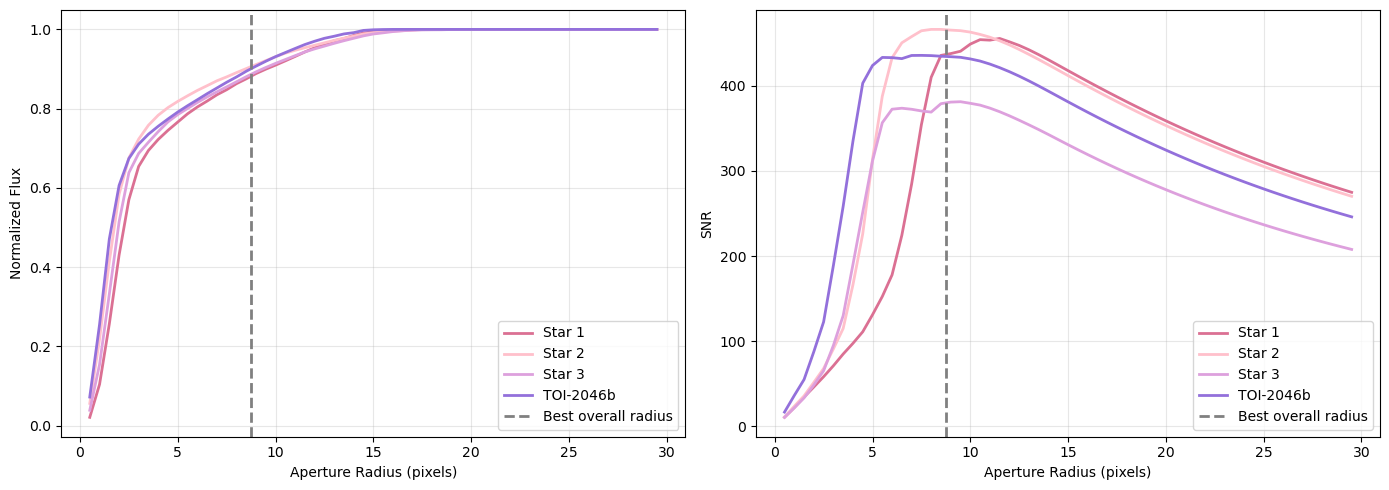

In [293]:
sci_files_ref1 = sorted(glob.glob(f"{my_path}/TOI-2046b_g_20251031_*_ref1.fits"))
sci_files_ref2 = sorted(glob.glob(f"{my_path}/TOI-2046b_g_20251031_*_ref2.fits"))
sci_files_ref3 = sorted(glob.glob(f"{my_path}/TOI-2046b_g_20251031_*_ref3.fits"))
sci_files_toi  = sorted(glob.glob(f"{my_path}/TOI-2046b_g_20251031_*_toi.fits"))

groups = {
    "Star 1": sci_files_ref1,
    "Star 2": sci_files_ref2,
    "Star 3": sci_files_ref3,
    "TOI-2046b": sci_files_toi,
}

# -------------------------------
# Constants
# -------------------------------
GAIN = 1.260 # electrons per ADU
READ_NOISE = 19.544  # electrons

# -------------------------------
# Aperture radii
# -------------------------------
radii = np.arange(0.5, 30, 0.5)

# Colors for plotting
colors = ["palevioletred", "pink", "plum", "mediumpurple"]

# -------------------------------
# Utilities
# -------------------------------
def get_star_center(data):
    """Assume star is centered in cropped frame."""
    y0 = data.shape[0] / 2
    x0 = data.shape[1] / 2
    return x0, y0

def growth_curve(file_list):
    """Return median normalized flux vs radius for a set of cutouts."""
    fluxes_all = []

    for fname in file_list:
        with fits.open(fname) as hdul:
            data = hdul[0].data.astype(float)
            header = hdul[0].header
            gain = header.get('GAIN', 1.0)

        # centroid of the star
        x, y = centroid_com(data)

        # flux vs radius
        fluxes_frame = []
        for r in radii:
            ap = CircularAperture((x, y), r=r)
            phot = aperture_photometry(data, ap)
            fluxes_frame.append(phot['aperture_sum'][0] / gain)

        fluxes_all.append(fluxes_frame)

    fluxes_all = np.array(fluxes_all)
    med_flux = np.median(fluxes_all, axis=0)
    med_flux_norm = med_flux / med_flux[-1]  # normalize
    return med_flux_norm

def snr_vs_radius(file_list):
    """Compute median SNR vs radius over a set of cutouts."""
    data0 = fits.getdata(file_list[0])
    x0, y0 = get_star_center(data0)

    snrs = np.zeros((len(radii), len(file_list)))

    for j, fname in enumerate(file_list):
        data = fits.getdata(fname)

        for i, r in enumerate(radii):
            ap = CircularAperture((x0, y0), r=r)
            phot = aperture_photometry(data, ap)
            flux_adu = phot["aperture_sum"][0]
            flux_e = flux_adu * GAIN
            n_pix = np.pi * r**2
            noise = np.sqrt(flux_e + n_pix * READ_NOISE**2)
            snrs[i, j] = flux_e / noise

    return np.median(snrs, axis=1)

# -------------------------------
# Compute SNR curves
# -------------------------------
snr_curves = {label: snr_vs_radius(files) for label, files in groups.items()}

# -------------------------------
# Find optimal radius per star
# -------------------------------
optimal_radii = {}
for label, snr in snr_curves.items():
    idx_max_snr = np.argmax(snr)
    r_opt = radii[idx_max_snr]
    optimal_radii[label] = r_opt
    print(f"{label}: Optimal aperture radius ≈ {r_opt:.2f} pixels (SNR max)")

# -------------------------------
# Compute best overall radius
# -------------------------------
best_overall_radius = np.median(list(optimal_radii.values()))
print(f"Best overall aperture radius ≈ {best_overall_radius:.2f} pixels")

# -------------------------------
# Plot growth curves and SNR side by side
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Growth curves
for files, color, label in zip([sci_files_ref1, sci_files_ref2, sci_files_ref3, sci_files_toi],
                               colors, ["Star 1","Star 2","Star 3","TOI-2046b"]):
    flux_norm = growth_curve(files)
    axes[0].plot(radii, flux_norm, color=color, lw=2, label=label)

axes[0].axvline(best_overall_radius, ls='--', color='gray', lw=2, label='Best overall radius')
axes[0].set_xlabel("Aperture Radius (pixels)")
axes[0].set_ylabel("Normalized Flux")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: SNR curves
for label, snr in snr_curves.items():
    axes[1].plot(radii, snr, color=colors[list(snr_curves.keys()).index(label)],
                 lw=2, label=label)

axes[1].axvline(best_overall_radius, ls='--', color='gray', lw=2, label='Best overall radius')
axes[1].set_xlabel("Aperture Radius (pixels)")
axes[1].set_ylabel("SNR")
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [292]:
# ---------------------------------------------
# Compute individual background annuli
# ---------------------------------------------
background_annuli = {}
for label, r_ap in optimal_radii.items():
    r_in = r_ap + 2     # inner radius slightly larger than aperture
    r_out = r_ap + 6    # outer radius
    background_annuli[label] = (r_in, r_out)
    print(f"{label}: Background annulus = ({r_in:.1f}, {r_out:.1f}) pixels")

# ---------------------------------------------
# Compute best overall background annulus
# ---------------------------------------------
r_in_all = [r_ap + 2 for r_ap in optimal_radii.values()]
r_out_all = [r_ap + 6 for r_ap in optimal_radii.values()]

best_background_annulus = (np.median(r_in_all), np.median(r_out_all))
print(f"Best overall background annulus = ({best_background_annulus[0]:.1f}, "
      f"{best_background_annulus[1]:.1f}) pixels")

Star 1: Background annulus = (13.5, 17.5) pixels
Star 2: Background annulus = (10.0, 14.0) pixels
Star 3: Background annulus = (11.5, 15.5) pixels
TOI-2046b: Background annulus = (9.5, 13.5) pixels
Best overall background annulus = (10.8, 14.8) pixels


## Magnitudes

In [294]:
target_fraction = 0.8  # choose 80% of total flux

fixed_radii = {}
for label, files in groups.items():
    flux_norm = growth_curve(files)
    # find radius where flux_norm crosses target_fraction
    idx = np.argmin(np.abs(flux_norm - target_fraction))
    r_fixed = radii[idx]
    fixed_radii[label] = r_fixed
    print(f"{label}: Radius for {target_fraction*100:.0f}% flux ≈ {r_fixed:.2f} pixels")

# Optionally choose a single radius across all stars
best_fixed_radius = np.median(list(fixed_radii.values()))
print(f"Best fixed radius for {target_fraction*100:.0f}% flux ≈ {best_fixed_radius:.2f} pixels")

Star 1: Radius for 80% flux ≈ 6.00 pixels
Star 2: Radius for 80% flux ≈ 4.50 pixels
Star 3: Radius for 80% flux ≈ 5.50 pixels
TOI-2046b: Radius for 80% flux ≈ 5.50 pixels
Best fixed radius for 80% flux ≈ 5.50 pixels
